# Week 06, ASTR 596: Fundamentals of Data Science


## Posterior Predictive Checks, and connecting the Bayesian and Frequentist Worlds


### Gautham Narayan 
##### <gsn@illinois.edu>

## Recap:

More useful MCMC tools:
* **Affine-invariant MC** (emcee) - works great as long as posterior is "nice" after affine transformation
    * counter-examples: Rosenbrock function, eggbox 
* **Parallel-tempering** (now, ptemcee) - adds chains at multiple temperatures (we care about T=1) 
    * connection to simulated annealing
    * computationally more intensive, even with a low number of dimensions
* **Gibbs Sampling** (special choice of prior, but if applicable to your problem, acceptance fraction = 1.)
    * connection to probability integral transform 
    * not very general, but most common way to deal with high dimensional spaces 
* Useful if overlooked - **you don't have to update all of the parameters of your model the same way**
    * i.e. you can look up something like **Metropolis within Gibbs**

## Recap:    
    
* All of these are specializations of MH (different starting positions, different number of chains, different proposals distributions) 
    * **None require evaluation of derivatives** - which is the general situation you'll be in with astrophysics
    * There are packages that will do automatic differentiation for you (e.g. `pymc3` which uses `theano`, `tensorflow`), but these can be "fragile" with real data

## Big Picture: Frequentist Statistics

* **Frequentists** make statements about the data (or statistics or estimators= functions of the data), conditional on the parameter: 

# $$p(D|\theta) \mathrm{\;or\;} p(f(D) |\theta)$$

* The goal is to get a “point estimate” or confidence intervals with good properties/coverage under “long-run” repeated experiments in the magic wonderland of Asymptopia.
    * Confidence intervals - arguments are based on datasets that could have happened but didn't.

## Big Picture: Bayesian Statistics

* Bayesians make statements about the probability of parameters conditional on the dataset $D$ that you actually observed

# $$p(\theta|D)$$

* This requires an interpretation of probability as a quantifying degree of belief in a hypothesis. This exists without any data even - i.e. **the prior**
    * Credible regions - arguments are based on variables you wish you observed but didn't (nuisance parameters/latent variables) 
    * This is not an equivalent shortcoming to the frequentist approach - it actually matches how reality works

## Big Picture: MCMC

* The Bayesian answer is the full posterior density, quantifying the "state of knowledge" after seeing the data
    * The likelihood is not a probability density in the parameters.
        * But multiply by a prior (even flat) and the posterior is a probability that obeys clear rules:
            * Conditional/Marginal probability
* **Numerical estimates (such as samples using Monte Carlo methods) are attempts to (imperfectly) summarize the posterior**
    * These techniques give us ways to deal with high-dimensional spaces e.g. many latent variables
        * Convert messy integrals to simple sums over samples
            * **All those frequentist statistics/estimators are still useful given MCMC samples!**

    
## Advice: MCMC

* MCMC is a terrible optimizer. If you just want the "best-fit", some local/global optimizer is often quicker.
    * These are often useful for reasonable starting guesses
    * Bayesians will often need to introduce latent variables/nuisance parameters/things you don't observe but wish you did 
    * Coming up with the likelihood is not the same as writing down the model
    * These parameters make the problem very high dimensional, even if you don't care about them
    * The point of it is to sample the full posterior distribution so you have reasonable **credible regions**
        * You are scientists and this is what you actually want
            * **You write down the model and likelihood, and the Bayesian framework tells you what distribution of parameters is feasible given your data and your prior belief**

# For Fun: MCMC sampler visulations for different functions, without an annoying soundtrack:

# <center>[http://chi-feng.github.io/mcmc-demo/](http://chi-feng.github.io/mcmc-demo/)</center>

(There is only so many times you can listen to the Harlem shake - Hungarian dances for sorting algorithms are more fun)

## Posterior-predictive checks

* Nothing about the Bayesian framework we've discussed tells us if our model is right
    * MCMC can give us very precise, but very wrong inferences, if the model itself is inadequate
     
     
Let's look at the posterior again
## $$ P(\theta|D) \mathrm{\; is \; really \;} P(\theta|D, H) $$ 
i.e. assuming the hypothesis $H$ is itself correct.

## Posterior-predictive checks

Frequentists have a way to express the question we're asking

## $$P(D|H)$$
i.e. "how likely is the data given the hypothesis", which is similar to but not exactly the same as  "how likely is the data given the model parameters of this hypothesis"

The two are related though!

## $$P(D|H) = \int_{\theta} P(D|\theta) \cdot P(\theta|H)$$

This is the **predictive distribution** - the distribution of imaginary datasets if the hypothesis/model is true.

* i.e. if you have some observations $y_D$, and you can infer a model and then ask what we would expect to see in hypothetical replications of the same experiment.

* if the model is right, you expect to see something similar to what you did the first time

## Posterior-predictive checks

* THIS IS A FREQUENTIST IDEA!
* The idea is to generate data from the model using parameters from draws from the posterior.

## Big picture

* Bayes theory is needed to *estimate* parameters, conditional on observations and a model we are considering
* Frequentist theory is needed to *critique* a model conditioned on the data we observe, by exploring if the model actually is *likely* to generate data like our observations in the first place

## Let's try posterior predictive checks on a simple linear model.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
import pymc as pm
import arviz as az

In [2]:
# AND THIS

# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# convert the data to numpy arrays
x  = np.array(x)
y  = np.array(y)
dy = np.array(dy)

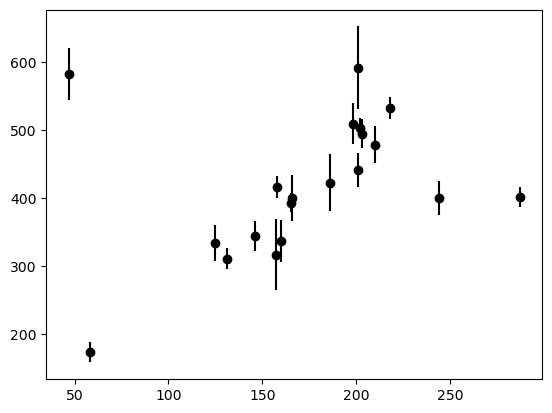

In [3]:
# We can check that the data is what we've already seen
# And you should definitely be looking at this and making a 
# qualitative comparison to the Cepheid data on your midterm
plt.errorbar(x, y, yerr=dy, linestyle='None', color='k', marker='o');

# Next, we're going to use `pymc3` to fit this model, but we're going to be naive and use a Gaussian likelihood, despite knowing there are outliers.

In [4]:
basic_model = pm.Model()

with basic_model:
    # write down expressions for the priors on the slope and intercept of the line 
    m = pm.Normal('m', mu=2, sigma=5)
    b = pm.Normal('b', mu=60, sigma=70)

    # write down your model
    ymod = m*x + b

    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    likelihood = pm.Normal('likelihood', mu=ymod, sigma=dy, observed=y)

    
    # and then to sample!
    samples_ols = pm.sample(5000, cores=2) # draw 5000 posterior samples 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 22 seconds.


# Next make a traceplot of your samples

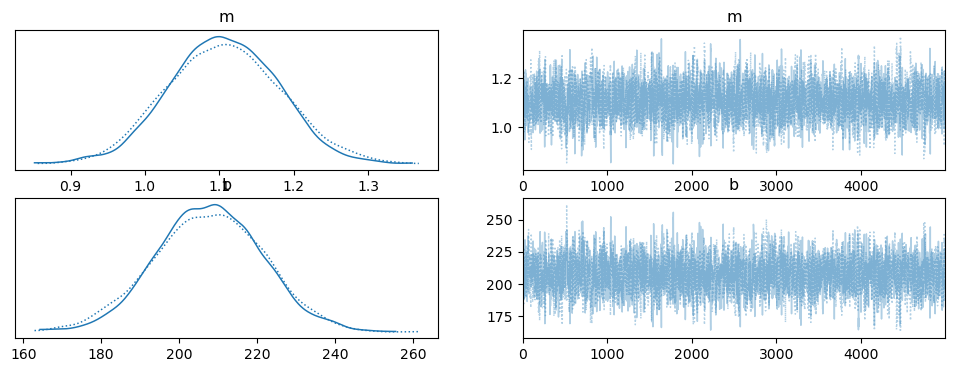

In [5]:
# You could use matplotlib and look at each variable in your chain
# but pymc3 is much more user friendly and lets you do traceplots quickly
pm.plot_trace(samples_ols);

# If your traceplot looks ok, get some summary statistics from your trace

In [6]:
# you could also do something like np.percentile(samples_ols['m'], [16, 50, 84]) to get statistics
# but pymc3 is really user friendly so:
pm.summary(samples_ols)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,1.106,0.074,0.963,1.240,0.001,0.001,2751.0,2615.0,1.0
b,207.570,13.759,181.517,233.526,0.268,0.190,2630.0,2551.0,1.0


# Now lets see how if our data looks anything like data generated from the model suggest

Sampling: [likelihood]


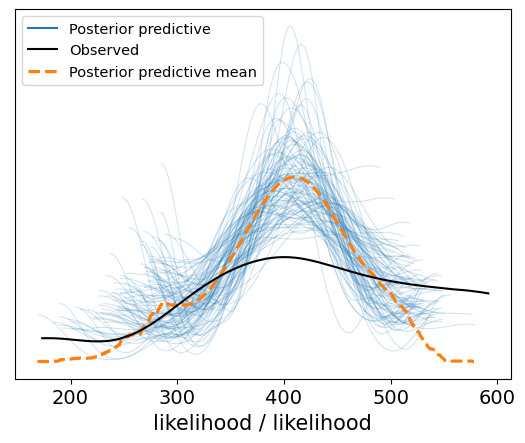

In [7]:
# RUN THIS

ppc = pm.sample_posterior_predictive(samples_ols,  model=basic_model)
az.plot_ppc(ppc, num_pp_samples=100);



# hmm  - our posterior predictive samples don't look very much like our "observed" data - let's see if we can do better if we use a different model, since we know least squares is impacted by outliers.

# Next we're going to try an alternative model, where our likelihood is a Student-T distribution rather than a Normal one. The Student-T remember has fatter tails than a Gaussian, so there is a higher probability of points being farther out - i.e. it's resilient to outliers. 

# It is characterized by a number of degrees of freedom, $nu$. This is *NOT* the number of degrees of freedom of the problem but rather a nuisance parameter that allows the tails of the distribution to be thinner/fatter.

# Since this is a parameter, it needs a prior. 

# It can't be less that 0 (or really less than 1, where the Student-T has infinite variance). We also know that $nu$ can't be really high, because in that limit the Student-T looks like a Gaussian, which would imply no outliers, and we know there are from just *looking at the data*.

# I picked a HalfCauchy distribution - you can pick something else if you like.

# Colin also suggested that the slope isn't negative, so we could use a Half-normal if we like. Half-Normals are defined like a Normal centered at 0 with the left half truncated, which isn't what we want, but we can add a bound to a standard normal distribution with some $\mu$ - I've bounded it at 2 in this example -i.e. we know that Colin is right and the slope is higher than 2. 

In [8]:
with pm.Model() as model2:
    # write down expressions for the priors on the slope and intercept of the line 
    
    # https://docs.pymc.io/api/distributions/continuous.html
    # they are all in the form of 
    # Distribution('variable name', parameters of distribution)
    # e.g. Normal('blah', mu=0, sigma=1)
    
    b = pm.Normal('b', mu=60, sigma=70)
    m = pm.Truncated(name='m', dist=pm.Normal.dist(mu=2.0, sigma=5.0), lower=2)
    nu = pm.HalfCauchy('nu', beta=3)

    # write down your model
    ymod = m*x + b

    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    likelihood = pm.StudentT('likelihoodT', mu=ymod, nu=nu, sigma=dy, observed=y)

    
    # and then to sample!
    samples_T = pm.sample(5000, cores=2) # draw 5000 posterior samples 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m, nu]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 38 seconds.


# Note how the posterior distribution in the slope $m$ looks now! 

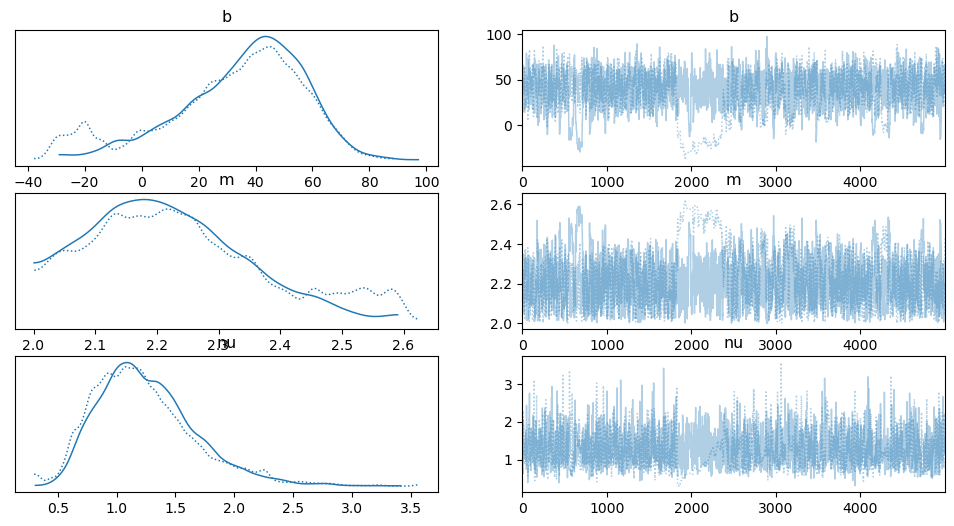

In [9]:
pm.plot_trace(samples_T);

# As before we generate posterior predictive samples - i.e. samples that are generated, drawing from the posterior distribution.

Sampling: [likelihoodT]


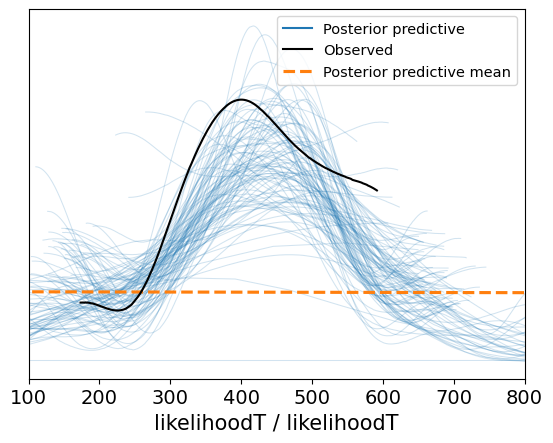

In [10]:
ppcT = pm.sample_posterior_predictive(samples_T, model=model2)
az.plot_ppc(ppcT, num_pp_samples=100);
ax = plt.gca()
ax.set_xlim(100, 800);

# This looks better - our posterior predictive draws do look like the observed data more, even if the posterior predictive mean is junk (remember a Student's T is trouble because it allows very large outliers)

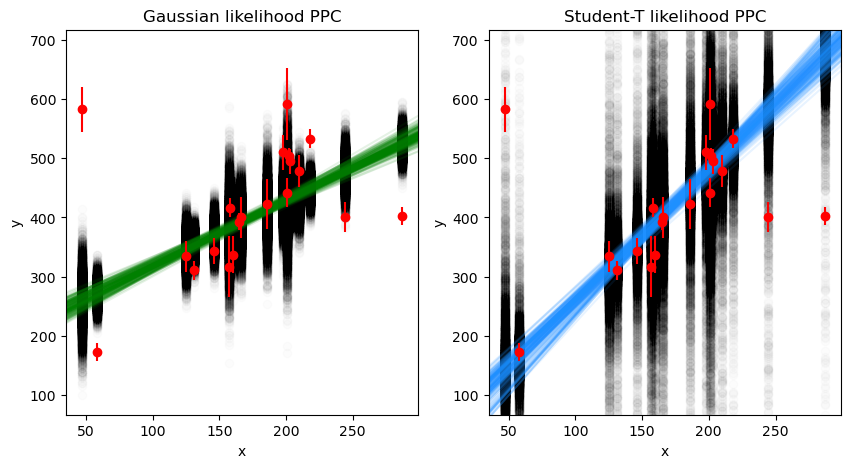

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)


# draw 200 random samples from the posteriors
nsamp = 200
big_m = samples_ols.posterior['m'].values.ravel()
big_b = samples_ols.posterior['b'].values.ravel()
big_m2 = samples_T.posterior['m'].values.ravel()
big_b2 = samples_T.posterior['b'].values.ravel()

i = np.random.choice(range(big_m.shape[0]), size=nsamp)
m = big_m[i]
b = big_b[i]
m2 = big_m2[i]
b2 = big_b2[i]



# plot the posterior predictive samples for the Gaussian
for i in range(ppc['posterior_predictive']['likelihood'].shape[0]):
    ymod = ppc['posterior_predictive']['likelihood'][i,:].T
    ax.plot(x, ymod, 'ko', alpha=0.01)
    
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
  
# plot the posterior predictive samples for the student T
for i in range(ppcT['posterior_predictive']['likelihoodT'].shape[0]):
    ymod = ppcT['posterior_predictive']['likelihoodT'][i,:].T
    ax2.plot(x, ymod, 'ko', alpha=0.01) 

xarr = np.array([xmin, xmax])
for mx, bx in zip(m, b):
    ax.plot(xarr, mx*xarr + bx, alpha=0.1, color='green')
    
for mx, bx in zip(m2, b2):
    ax2.plot(xarr, mx*xarr + bx, alpha=0.1, color='dodgerblue')
    
    
ax.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')
ax2.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')

ax.set_title('Gaussian likelihood PPC')
ax2.set_title('Student-T likelihood PPC')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')


ax2.set_xlim([xmin, xmax])
ax.set_ylim([0.9*ymin, 1.1*ymax])
ax2.set_ylim([0.9*ymin, 1.1*ymax]);

## You should be able to see that the posterior predictive samples from the Student-T model are a much better match to the real observations - there's more outliers, like we actually get, but they don't weight the fit as much so the slope is more reasonable. 



## [PyMC implementation of the Outlier model we used with `emcee`](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html)


## Now that we have our samples from two models, we can do something else - model comparison. We'll use a techinique called "Leave One Out"

## LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. 


## If f is the true model, y be the observed data, and ~y be future data or alternative data not used in fitting the model. The out-of-sample predictive fit for new data is 

## $$\log p_{\text {post }}\left(\tilde{y}_i\right)=-\log \mathrm{E}_{\text {post }}\left(p\left(\tilde{y}_i\right)\right)=\log \int p\left(\tilde{y}_i \mid \theta\right) p_{\text {post }}(\theta) d \theta$$

## where $p_{\text {post }}\left(\tilde{y}_i\right)$ is the predictive density for $\tilde{y}_i$ from $p_{\text {post }}(\theta)$. $\mathrm{E}_{\text {post }}$ is an expectation that averages over the values posterior distribution of $\theta$.



## Since the future data $\tilde{y}_i$ are unknown, the expected out-of-sample log predictive density (ELPD) is, 

## $$
\begin{aligned}
\text {ELPD} & =\text { expected log predictive density for a new data point } \\
& =E_f\left(\log p_{\text {post }}\left(\tilde{y}_i\right)\right) \\
& =\int\left(\log p_{\text {post }}\left(\tilde{y}_i\right)\right) f\left(\tilde{y}_i\right) d \tilde{y}_i
\end{aligned}$$

## [Vehtari et al. (2016)](https://arxiv.org/pdf/1507.04544.pdf) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. 

## The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS). You don't need to know this for the midterm, but the basic idea is your existing samples can be used to evaluate what happens when a point is removed.

## You do need one thing pymc doesn't store when it stores the chains - the likelihood.

In [12]:
with basic_model:
    pm.compute_log_likelihood(samples_ols)

In [13]:
with model2:
    pm.compute_log_likelihood(samples_T)

In [14]:
ols_loo = az.loo(samples_ols)
t_loo   = az.loo(samples_T)

print("# OLS")
print(ols_loo)

print("Student T likelihood")
print(t_loo)

# OLS
Computed from 10000 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -262.72    62.15
p_loo       56.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       15   75.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         3   15.0%
   (1, Inf)   (very bad)    2   10.0%

Student T likelihood
Computed from 10000 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -117.04     7.89
p_loo        3.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       19   95.0%
 (0.5, 0.7]   (ok)          1    5.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


In [15]:
# finally we can actually compare tw models
df_comp_loo = az.compare({"ols": samples_ols, "t": samples_T})

/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


In [16]:
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
t,0,-117.043697,3.689478,0.000000,1.0,7.893827,0.000000,False,log
ols,1,-262.715894,56.556241,145.672197,0.0,62.148709,57.176871,True,log


We have many columns, so let’s check out their meaning one by one:

    The index is the names of the models taken from the keys of the dictionary passed to compare(.).

    rank, the ranking of the models starting from 0 (best model) to the number of models.

    elpd_loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

    p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

    elpd_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

    weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

    se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

    dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

    warning, If True the computation of LOO/WAIC may not be reliable.

    scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).


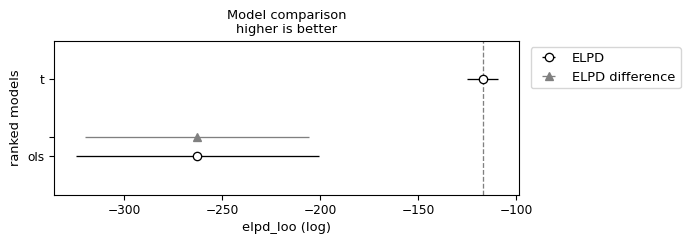

In [17]:
# this summarizes the result in plot form
az.plot_compare(df_comp_loo, insample_dev=False);